# Preprocessing Data : 

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter
import numpy as np

### Convert duration of all movies to minute  

In [8]:
df = pd.read_csv("imdb.csv")

def convert_duration(duration):
    parts = duration.split()
    total_minutes = 0
    for part in parts:
        if 'h' in part:
            total_minutes += int(part.rstrip('h')) * 60
        elif 'm' in part:
            total_minutes += int(part.rstrip('m'))
    return total_minutes

df['Duration'] = df['Duration'].apply(convert_duration)

print(df['Duration'])


0       142
1       152
2       148
3       139
4       142
       ... 
4718     95
4719    115
4720    119
4721    139
4722    112
Name: Duration, Length: 4723, dtype: int64


In [9]:
df['Meta Score'] = df['Meta Score'].astype(int)

### Number of vote preprocessing

In [10]:
def convert_votes(votes_str):
    if 'K' in votes_str:
        return int(float(votes_str.rstrip('K')) * 1000)
    elif 'M' in votes_str:
        return int(float(votes_str.rstrip('M')) * 1000000)
    else:
        return int(votes_str)

df['Number of Votes'] = df['Number of Votes'].apply(convert_votes)

## Budget Preprocessing

In the dataset most of the budgets movie has been written in USD. We want to convert all of the budjets to USD to have a unique numerical variable.   

### Gross world wide feature

For clean this feature we should:

 - Remove $ sign.
 - Clean the budget value:
    Every 3 digits of budget has been seperated with ','. for example $200,500,000. It must convert to $20050000 

In [11]:
def convert_currency(value):
    if isinstance(value, str) and value.startswith('$'):
        return int(value.replace('$', '').replace(',', ''))
    else:
        return value

df['Gross (worldwide)'] = df['Gross (worldwide)'].apply(convert_currency)

### Budjet Feature

The budget feature has the problem to So we must clean the budget value.

In [12]:
def clean_budget_value(value):
        return str(value.replace(',', ''))
    
df['Budget'] = df['Budget'].apply(clean_budget_value)

All of the budgets are not in USD. The 'Budget' column contains various currency symbols. In this block of code we print them.

In [13]:
def extract_prefix(budget):
    match = re.match(r'([^\d]+)', str(budget).strip())
    if match:
        return match.group(1)
    return None


df['Prefix'] = df['Budget'].apply(extract_prefix)
unique_prefixes = df['Prefix'].dropna().unique()

unique_prefixes_list = unique_prefixes.tolist()
print(unique_prefixes_list)

['$', 'FRF\xa0', '€', '£', 'R$', '₹', '¥', 'DKK\xa0', 'DEM\xa0', '₩', 'CA$', 'RUR\xa0', 'ITL\xa0', 'CN¥', 'NOK\xa0', 'ATS\xa0', 'A$', 'SEK\xa0', 'BEF\xa0', 'THB\xa0', 'NZ$', 'SGD\xa0', 'HUF\xa0']


These prefixes appear to be international currency symbols and codes. The presence of non-breaking space characters (\xa0) indicates that some of the prefixes include a space character that might need to be cleaned up.

To convert the currency budget to USD, we'll need to use exchange rates for each currency.

Here’s a step-by-step approach:

1. **Define exchange rates** for each currency symbol.
2. **Extract the numeric part** and **currency prefix**.
3. **Convert the values** to USD using the exchange rates.
4. **Create a new column** with the converted value

In [14]:
exchange_rates = {
    '$': 1.0,       # USD to USD 
    'FRF': 0.17,    # French Franc to USD
    '€': 1.1,       # Euro to USD
    '£': 1.3,       # British Pound to USD
    'R$': 0.2,      # Brazilian Real to USD
    '₹': 0.012,     # Indian Rupee to USD
    '¥': 0.0073,    # Japanese Yen to USD
    'DKK': 0.15,    # Danish Krone to USD
    'DEM': 0.51,    # German Mark to USD
    '₩': 0.00079,   # South Korean Won to USD
    'CA$': 0.78,    # Canadian Dollar to USD
    'RUR': 0.014,   # Russian Ruble to USD
    'ITL': 0.00058, # Italian Lira to USD
    'CN¥': 0.16,    # Chinese Yuan to USD
    'NOK': 0.1,     # Norwegian Krone to USD
    'ATS': 0.08,    # Austrian Schilling to USD
    'A$': 0.76,     # Australian Dollar to USD
    'SEK': 0.12,    # Swedish Krona to USD
    'BEF': 0.027,   # Belgian Franc to USD
    'THB': 0.031,   # Thai Baht to USD
    'NZ$': 0.70,    # New Zealand Dollar to USD
    'SGD': 0.74,    # Singapore Dollar to USD
    'HUF': 0.0034   # Hungarian Forint to USD
}

def extract_currency_and_amount(budget):
    budget = str(budget).replace('\xa0', ' ').strip()
    match = re.match(r'([^\d\s]+)?\s?(\d+)', budget)
    if match:
        prefix = match.group(1)
        amount = match.group(2)
        return prefix, float(amount)
    return None, None

def convert_to_usd(prefix, amount):
    if prefix in exchange_rates:
        return amount * exchange_rates[prefix]
    return amount

df['Prefix'], df['Amount'] = zip(*df['Budget'].apply(extract_currency_and_amount))
df['Budget'] = df.apply(lambda row: convert_to_usd(row['Prefix'], row['Amount']), axis=1)
df = df.drop(columns=['Prefix', 'Amount'])

print(df['Budget'])

0        25000000.0
1       185000000.0
2       160000000.0
3        63000000.0
4        55000000.0
           ...     
4718     21150000.0
4719     13000000.0
4720      5850000.0
4721     30000000.0
4722     36000000.0
Name: Budget, Length: 4723, dtype: float64


### Reduce Budget and gross Digits
These numbers in the budget and gross are too big, compromising its readability. Let's convert the unit of the budget and gross columns from $ to million $ first.

In [15]:
df['Budget'] = df['Budget']/1000000
df['Gross (worldwide)'] = df['Gross (worldwide)']/1000000

df[['Budget', 'Gross (worldwide)']].describe()

,Budget,Gross (worldwide)
count,4723.000000,4723.000000
mean,41.263305,128.234328
std,47.449216,209.435145
min,0.001560,0.000126
25%,10.000000,19.004232
50%,25.000000,55.404207
75%,54.000000,147.907361
max,356.000000,2923.706026


In [16]:
print(df['Budget'])

0        25.00
1       185.00
2       160.00
3        63.00
4        55.00
         ...  
4718     21.15
4719     13.00
4720      5.85
4721     30.00
4722     36.00
Name: Budget, Length: 4723, dtype: float64


### Adding profit feature

The profit of a movie is a crusial measure for investor. In this notebook There are many analyzes to see the attributes of beneficial movies.

After cleaning the budget and world wide gross feature we can easily calculate the profit of movie. It contains the difference of the two columns: gross and budget.

In [17]:
df['profit'] = df['Gross (worldwide)'] - df['Budget']
df.head()
df.describe()   

,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit
count,4723.000000,4723.000000,4723.000000,4.723000e+03,4723.000000,4723.000000,4723.000000,4723.000000
mean,2003.634131,111.319500,6.661211,1.730934e+05,57.971840,41.263305,128.234328,86.971024
std,13.426662,20.303296,0.930746,2.319778e+05,17.924634,47.449216,209.435145,178.910050
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.004232,0.880617
50%,2006.000000,108.000000,6.700000,9.400000e+04,58.000000,25.000000,55.404207,28.117303
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.907361,97.340566
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026


## Companies Feature

In [18]:
all_companies = df['Companies'].str.split('~').explode()
company_counts = Counter(all_companies)
top_companies = company_counts.most_common(25)
top_df = pd.DataFrame(top_companies, columns=['Company', 'Frequency'])
print(top_df)
print(top_df['Frequency'].sum() / df.shape[0])

                      Company  Frequency
0                Warner Bros.        372
1          Universal Pictures        362
2           Columbia Pictures        315
3          Paramount Pictures        309
4       Twentieth Century Fox        220
5        Walt Disney Pictures        176
6             New Line Cinema        171
7   Metro-Goldwyn-Mayer (MGM)        113
8            Relativity Media        110
9         Dreamworks Pictures        107
10    New Regency Productions        105
11        Touchstone Pictures        105
12            Lionsgate Films         87
13  Village Roadshow Pictures         84
14                    Miramax         72
15       Summit Entertainment         70
16       Amblin Entertainment         59
17                StudioCanal         56
18                Screen Gems         55
19          Fox 2000 Pictures         54
20             Focus Features         54
21    Legendary Entertainment         53
22           TriStar Pictures         53
23      Imagine 

In [19]:
df.describe()

,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit
count,4723.000000,4723.000000,4723.000000,4.723000e+03,4723.000000,4723.000000,4723.000000,4723.000000
mean,2003.634131,111.319500,6.661211,1.730934e+05,57.971840,41.263305,128.234328,86.971024
std,13.426662,20.303296,0.930746,2.319778e+05,17.924634,47.449216,209.435145,178.910050
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.004232,0.880617
50%,2006.000000,108.000000,6.700000,9.400000e+04,58.000000,25.000000,55.404207,28.117303
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.907361,97.340566
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026


In [20]:
df.to_csv("preprocessed_imdb.csv", index=False)

# EDA : 

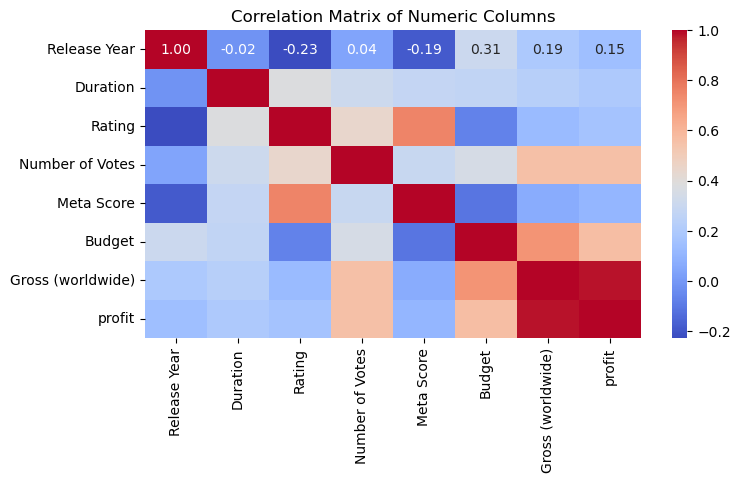

In [21]:
df = pd.read_csv("preprocessed_imdb.csv")

numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

#### Observations
This plot defines the correlation between features. By analysing this graph we can clearly understand 
- The proft , gross , budget and number of votes are highly dependable.
- The Rating and Meta score are highly dapendable.

### Profit and budget

By plotting the scatter plot and histogram of profit and budget we are going to visualize the relation of these features.

First we sort the dataset by profit in descending order.
 

In [22]:
sotredprofit_movies = df.sort_values(by='profit' , ascending=False)
sotredprofit_movies.head()

,Title,Release Year,Age Restriction,Duration,Genre,Rating,Number of Votes,Meta Score,Language,Country of Origin,Companies,Budget,Gross (worldwide),profit
29,Avatar,2009,PG-13,162,Action~Adventure~Fantasy,7.9,1400000,83,English~Spanish,United States,Twentieth Century Fox~Dune Entertainment~Light...,237.0,2923.706026,2686.706026
36,Avengers: Endgame,2019,PG-13,181,Action~Adventure~Drama,8.4,1300000,78,English~Japanese~Xhosa~German,United States,Marvel Studios~Walt Disney Pictures,356.0,2799.439100,2443.439100
34,Titanic,1997,PG-13,194,Drama~Romance,7.9,1300000,75,English~Swedish~Italian~French,United States~Mexico,Twentieth Century Fox~Paramount Pictures~Light...,200.0,2264.750694,2064.750694
323,Avatar: The Way of Water,2022,PG-13,192,Action~Adventure~Fantasy,7.6,493000,67,English,United States,20th Century Studios~TSG Entertainment~Lightst...,350.0,2320.250281,1970.250281
73,Star Wars: Episode VII - The Force Awakens,2015,PG-13,138,Action~Adventure~Sci-Fi,7.8,973000,80,English,United States,Lucasfilm~Bad Robot,245.0,2071.310218,1826.310218


c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

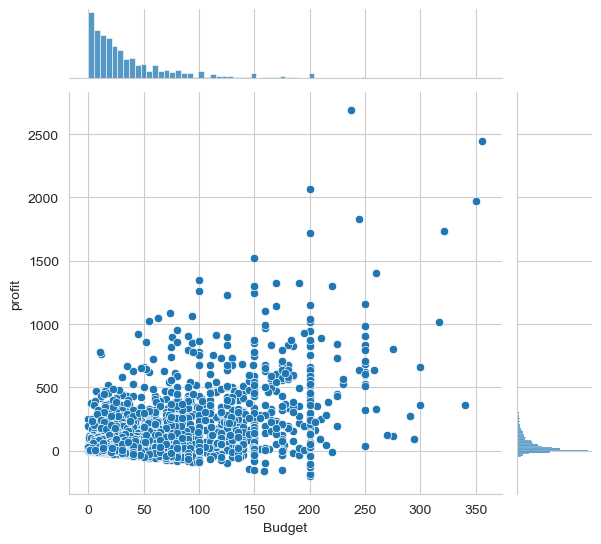

In [23]:
sns.set_style('whitegrid')

plt.figure(figsize=[8,6])
h= sns.jointplot(x='Budget', y='profit' , data=df)
plt.subplots_adjust(top=0.9)
plt.show()

#### Observations

- Most of movies were profitable.
- Both Budget and profit are slightly skewd to right which means most of the movies had positive profit.
- There is a positive relation between profit and budget.

### Profitable movies.

A new feature is added named isProfitable that is for recognizing the movies that has positive or negative profit.The positive profit is defined when the profid is greater than the double of our budget.

In [24]:
df['isProfitable'] = df['profit'] > (df['Budget']*2)

### Profitable and unprofitable movies properties

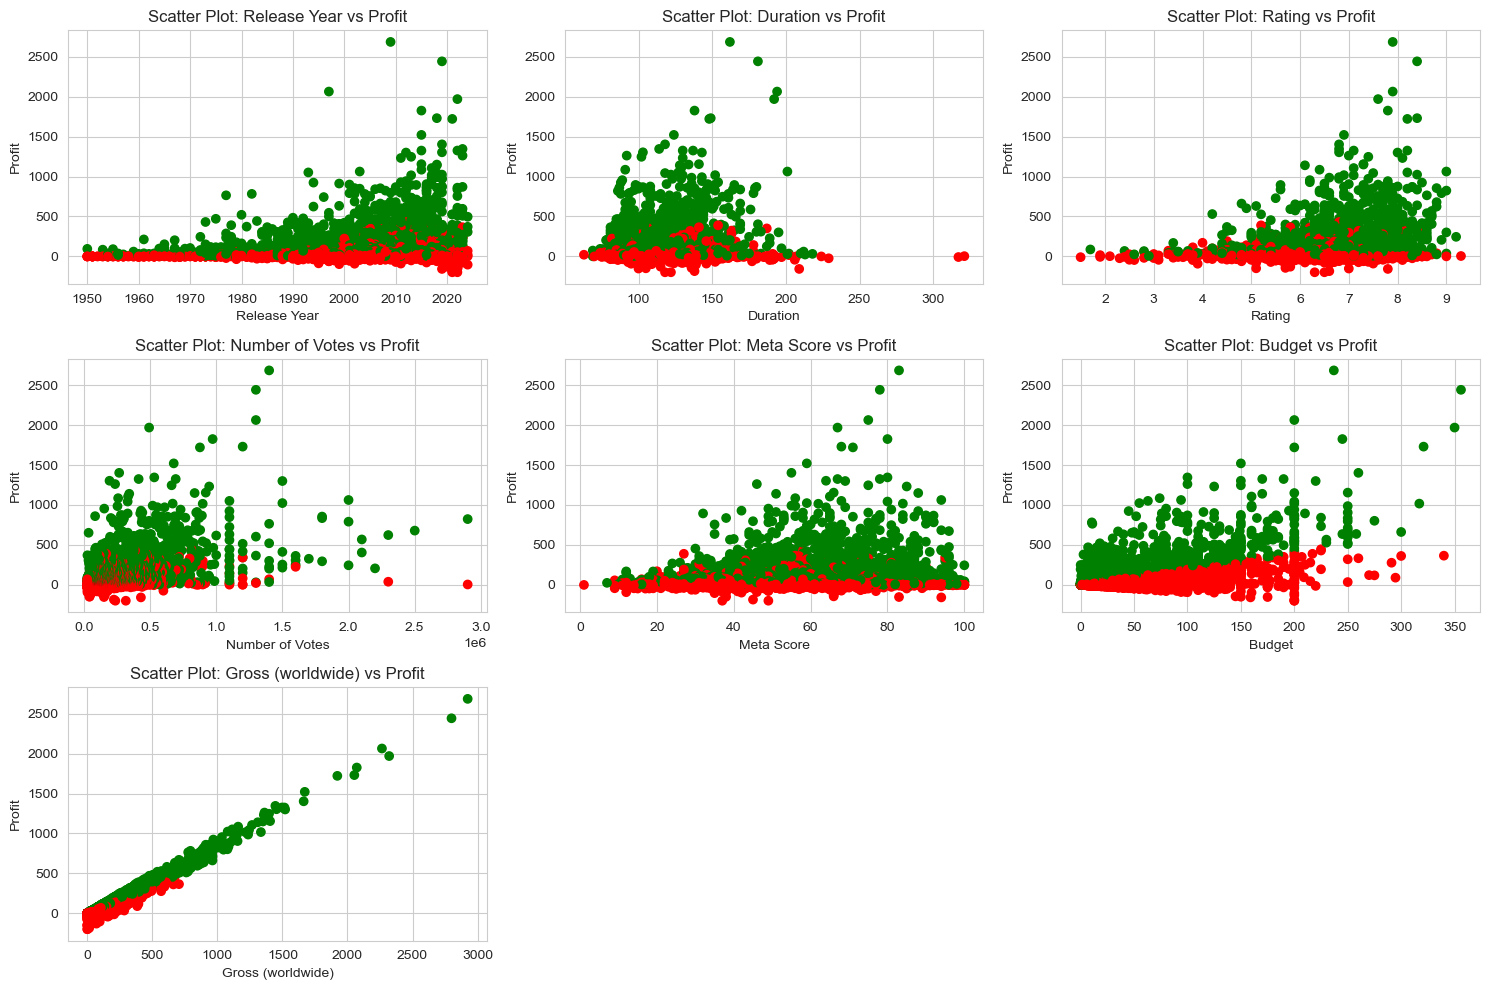

In [25]:
features = ['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score', 'Budget', 'Gross (worldwide)']


plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    plt.scatter(df[feature], df['profit'], c=df['isProfitable'].map({True: 'green', False: 'red'}))
    plt.xlabel(feature)
    plt.ylabel('Profit')
    plt.title(f'Scatter Plot: {feature} vs Profit')

plt.tight_layout()
plt.show()

#### Observations
- In the profit vs release dayums are skewed to the leftwhich means as time passed directors are better in producing profitable movies. 
- In the profit and rating plot datums are skewed to the left which means If the rating is higher, there is a lower chance that the film is unprofitable.

Now lets see the percentage of profitable and unprofitable movies for each feature.

C:\Users\behra\AppData\Local\Temp\ipykernel_16008\4041246411.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df.groupby('bin')['isProfitable'].value_counts(normalize=True).unstack().fillna(0)
C:\Users\behra\AppData\Local\Temp\ipykernel_16008\4041246411.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df.groupby('bin')['isProfitable'].value_counts(normalize=True).unstack().fillna(0)
C:\Users\behra\AppData\Local\Temp\ipykernel_16008\4041246411.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obser

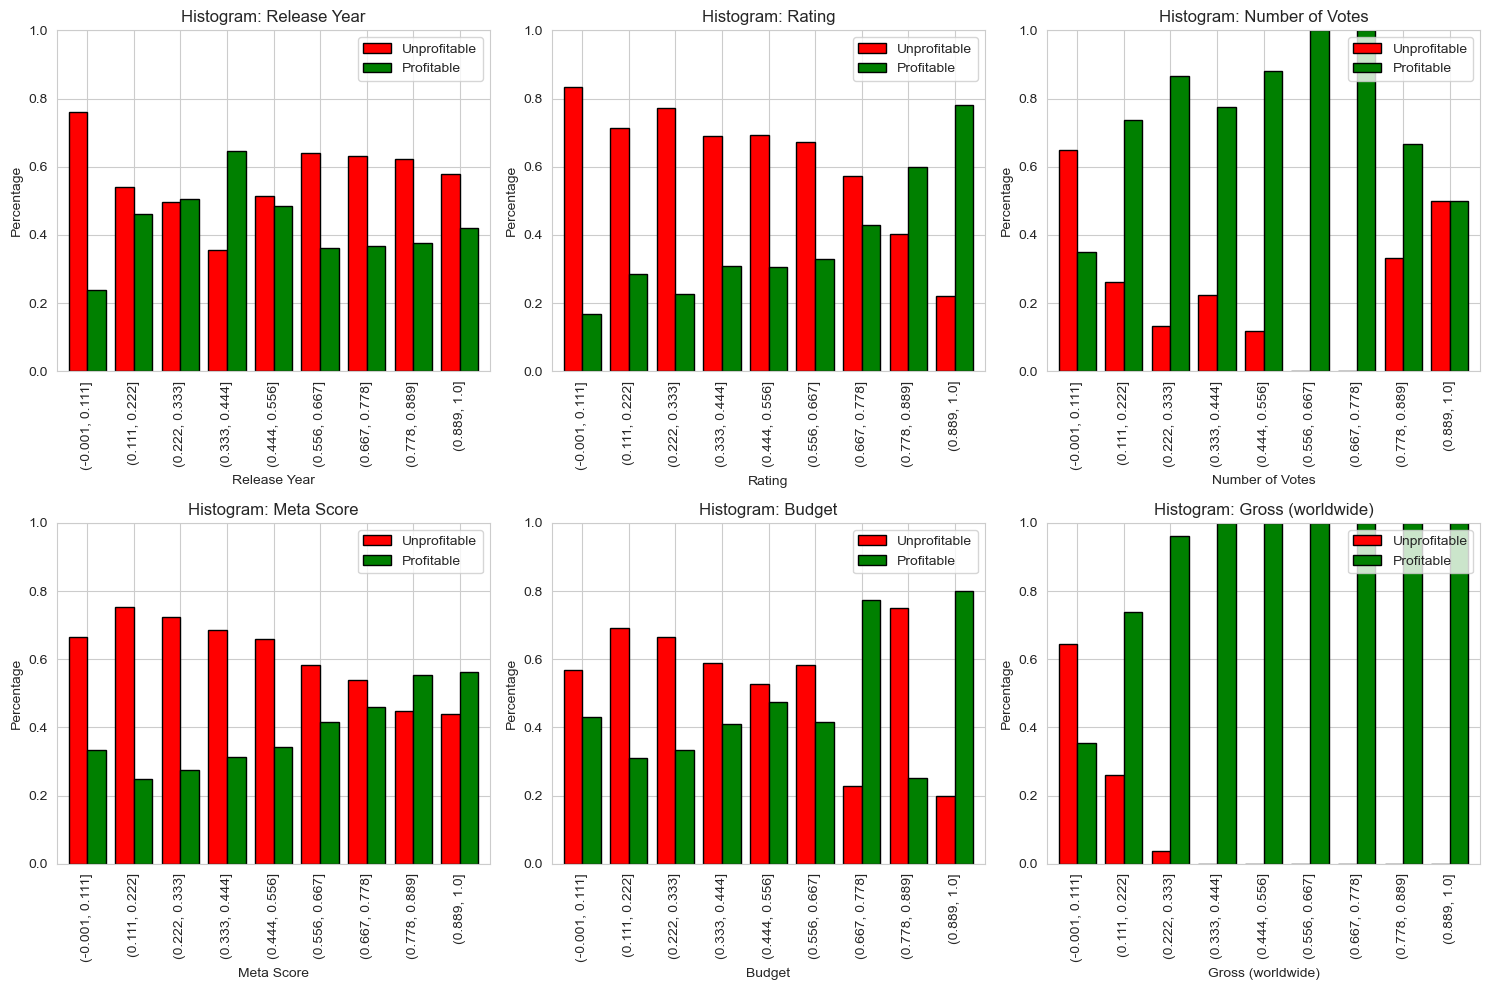

In [42]:
# Define the features to plot
features = ['Release Year', 'Rating', 'Number of Votes', 'Meta Score', 'Budget', 'Gross (worldwide)']

# Function to plot histograms with percentage of profitable and unprofitable movies
def plot_histograms(df, features):
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 3, i)
        
        # Bin the feature values
        bins = np.linspace(df[feature].min(), df[feature].max(), 10)
        df['bin'] = pd.cut(df[feature], bins, include_lowest=True)
        
        # Calculate the percentage of profitable and unprofitable movies in each bin
        normalize_stat = True

        bin_counts = df.groupby('bin')['isProfitable'].value_counts(normalize=True).unstack().fillna(0)
        
        # Plot the histograms
        bin_counts.plot(kind='bar', color=['red', 'green'], ax=plt.gca(), width=0.8, edgecolor='k')
        
        plt.xlabel(feature)
        plt.ylabel('Percentage')
        plt.title(f'Histogram: {feature}')
        plt.ylim(0, 1)
        plt.legend(['Unprofitable', 'Profitable'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Plot the histograms
plot_histograms(df, features)

#### Observations
- The propation of unprofitable movies decrease as the rating and metascore increases.
- The proporation of unprofitable has a incresing pulse in the past years.

### Top 10 Companies with most profit 

C:\Users\behra\AppData\Local\Temp\ipykernel_16008\2452677079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_profit_data['Companies'] = companies_profit_data['Companies'].str.split('~')


Companies
South Pictures                      0.669052
Jason Roberts Productions           0.669052
LuckyChap Entertainment             0.535405
Nintendo                            0.506447
Vita-Ray Dutch Productions (III)    0.382767
Pascal Pictures                     0.379095
Gadget Films                        0.370681
Walt Disney Studios                 0.368073
Lightstorm Entertainment            0.362116
Marzano Films                       0.343272
Name: profit, dtype: float64


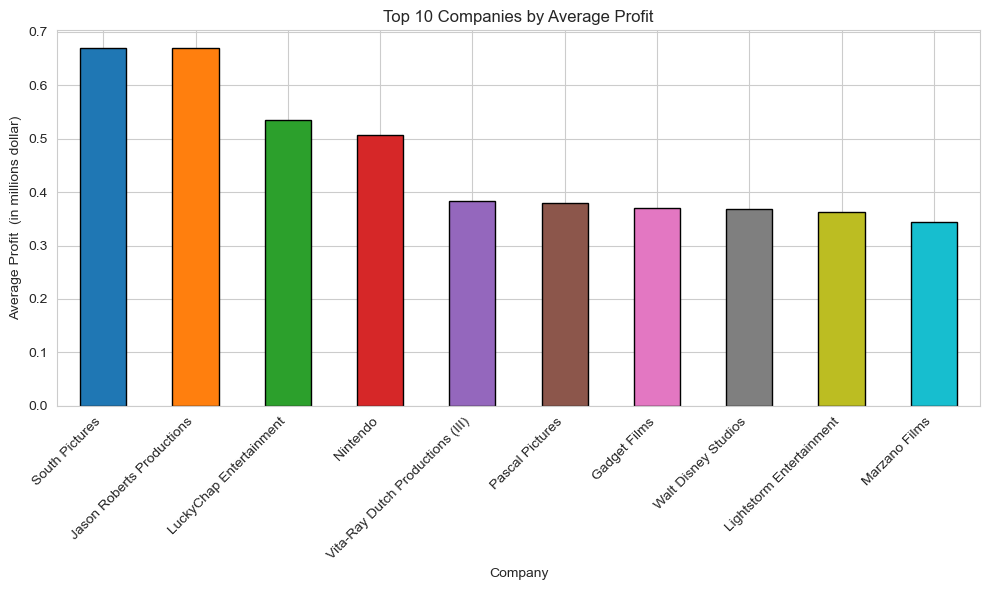

In [56]:
companies_profit_data = df[['Companies', 'profit']]


companies_profit_data['Companies'] = companies_profit_data['Companies'].str.split('~')
companies_profit_data = companies_profit_data.explode('Companies')


company_avg_profit = companies_profit_data.groupby('Companies')['profit'].mean().sort_values(ascending=False)


print(company_avg_profit.head(10))

top_10_companies = company_avg_profit.head(10)

colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 6))
top_10_companies.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Companies by Average Profit')
plt.xlabel('Company')
plt.ylabel('Average Profit  (in millions dollar)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Top Generes with most profit

C:\Users\behra\AppData\Local\Temp\ipykernel_16008\2615604276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_profit_data['Genre'] = genres_profit_data['Genre'].str.split('~')


Genre
Animation    0.147246
Adventure    0.135456
Sci-Fi       0.118182
Fantasy      0.115610
Family       0.114952
Action       0.114439
Comedy       0.098039
Thriller     0.093945
Musical      0.093263
Music        0.091291
Name: profit, dtype: float64


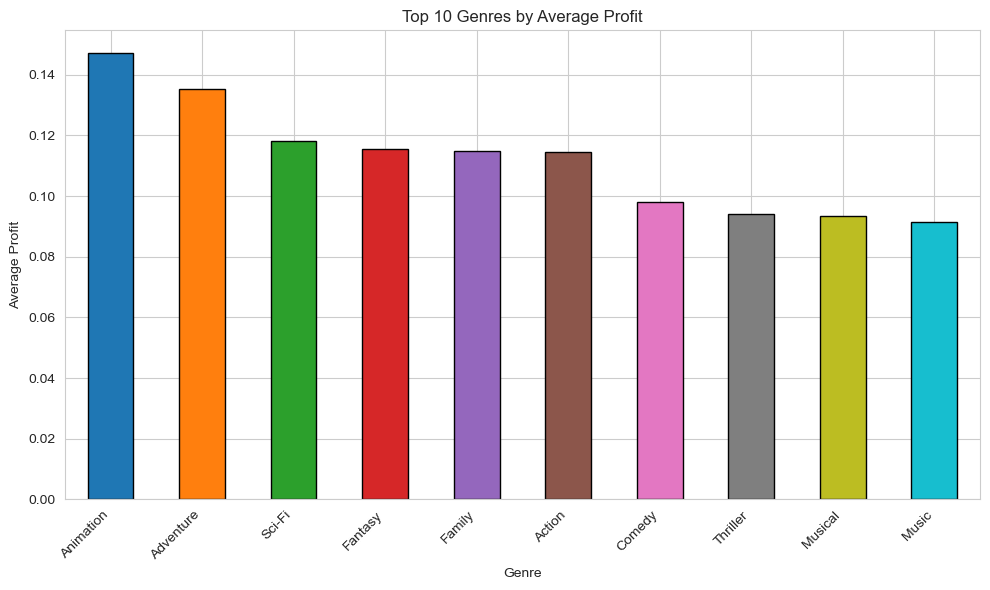

In [57]:

genres_profit_data = df[['Genre', 'profit']]

genres_profit_data['Genre'] = genres_profit_data['Genre'].str.split('~')
genres_profit_data = genres_profit_data.explode('Genre')


genre_avg_profit = genres_profit_data.groupby('Genre')['profit'].mean().sort_values(ascending=False)


print(genre_avg_profit.head(10))

top_10_genres = genre_avg_profit.head(10)

plt.figure(figsize=(10, 6))
top_10_genres.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Genres by Average Profit')
plt.xlabel('Genre')
plt.ylabel('Average Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Top languages with most profit

C:\Users\behra\AppData\Local\Temp\ipykernel_16008\3693080585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  languages_profit_data['Language'] = languages_profit_data['Language'].str.split('~')


Language
Nama           0.467603
Quenya         0.437350
Sindarin       0.382011
Maltese        0.359186
Xhosa          0.310752
Latvian        0.306138
Greenlandic    0.302389
Samoan         0.263484
Old English    0.251463
Malay          0.236456
Name: profit, dtype: float64


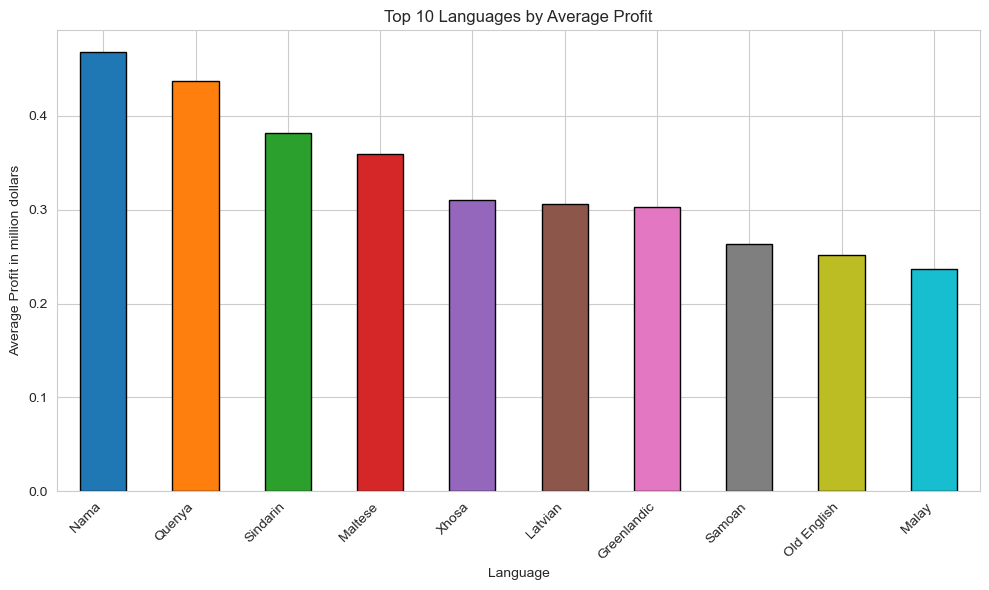

In [69]:
languages_profit_data = df[['Language', 'profit']]

languages_profit_data['Language'] = languages_profit_data['Language'].str.split('~')
languages_profit_data = languages_profit_data.explode('Language')

language_avg_profit = languages_profit_data.groupby('Language')['profit'].mean().sort_values(ascending=False)

language_avg_profit.to_csv('tset.csv')

print(language_avg_profit.head(10))

top_10_languages = language_avg_profit.head(10)

colors = plt.cm.tab10(np.linspace(0, 1, len(top_10_languages)))

plt.figure(figsize=(10, 6))
top_10_languages.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Languages by Average Profit')
plt.xlabel('Language')
plt.ylabel('Average Profit in million dollars')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

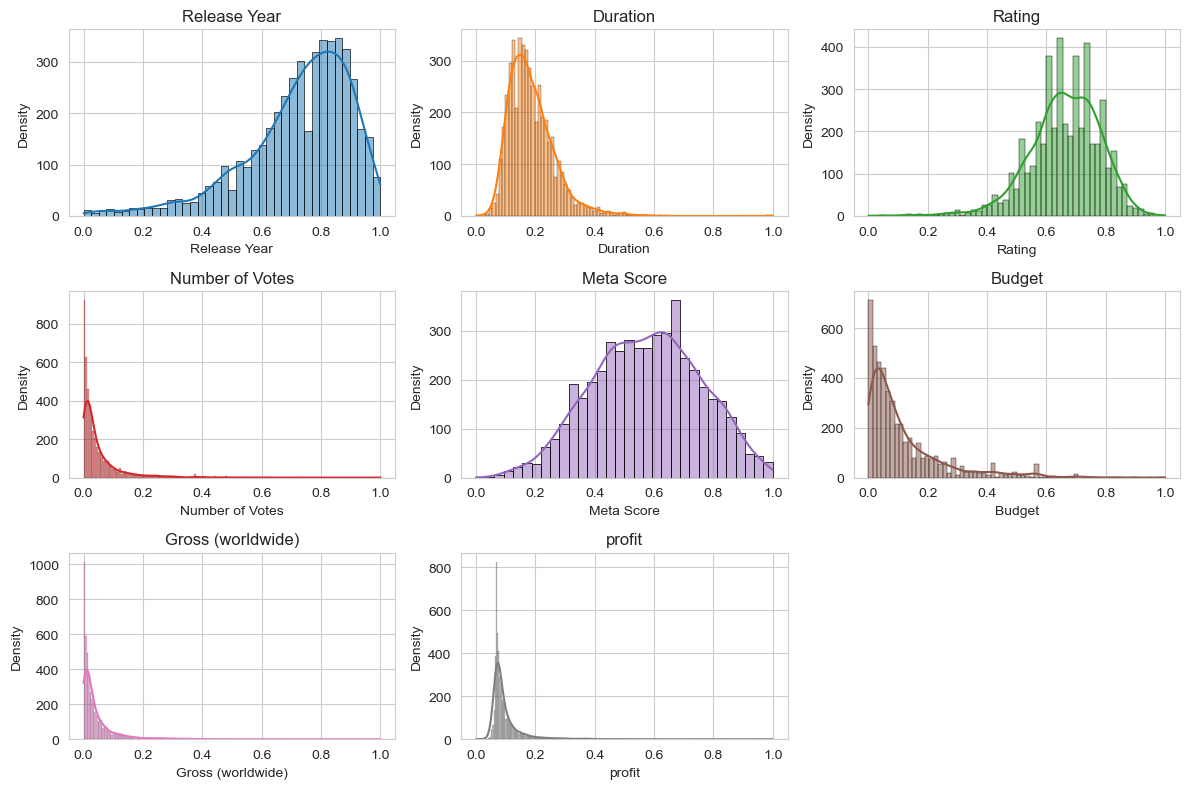

In [58]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, color=colors[i], edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

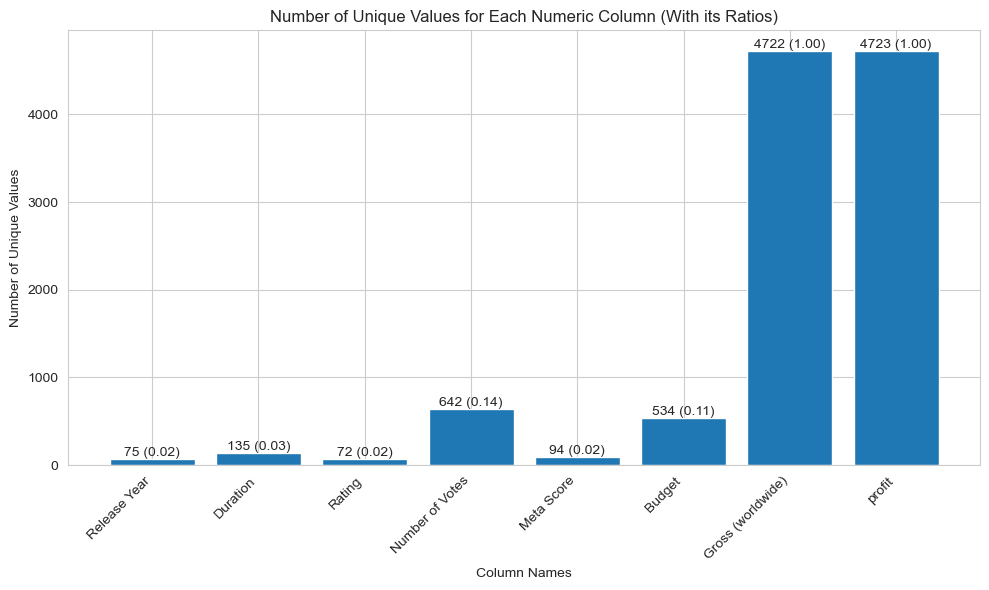

In [28]:
column_names = []
unique_value_counts = []
ratios = []

for column in numeric_columns.columns:
    column_names.append(column)
    unique_count = len(df[column].value_counts())
    unique_value_counts.append(unique_count)
    ratio = unique_count / len(df)
    ratios.append(ratio)

plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, unique_value_counts)
plt.xlabel('Column Names')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values for Each Numeric Column (With its Ratios)')
plt.xticks(rotation=45, ha='right')

for bar, count, ratio in zip(bars, unique_value_counts, ratios):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count} ({ratio:.2f})', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Normalizing the data:

In [29]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = df.select_dtypes(include=['int', 'float'])
print(numeric_columns.head().columns)
df[numeric_columns.columns] =  MinMaxScaler().fit_transform(numeric_columns)

numeric_columns = df[numeric_columns.columns]

Index(['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score',
       'Budget', 'Gross (worldwide)', 'profit'],
      dtype='object')


c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\behra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 1000x1000 with 0 Axes>

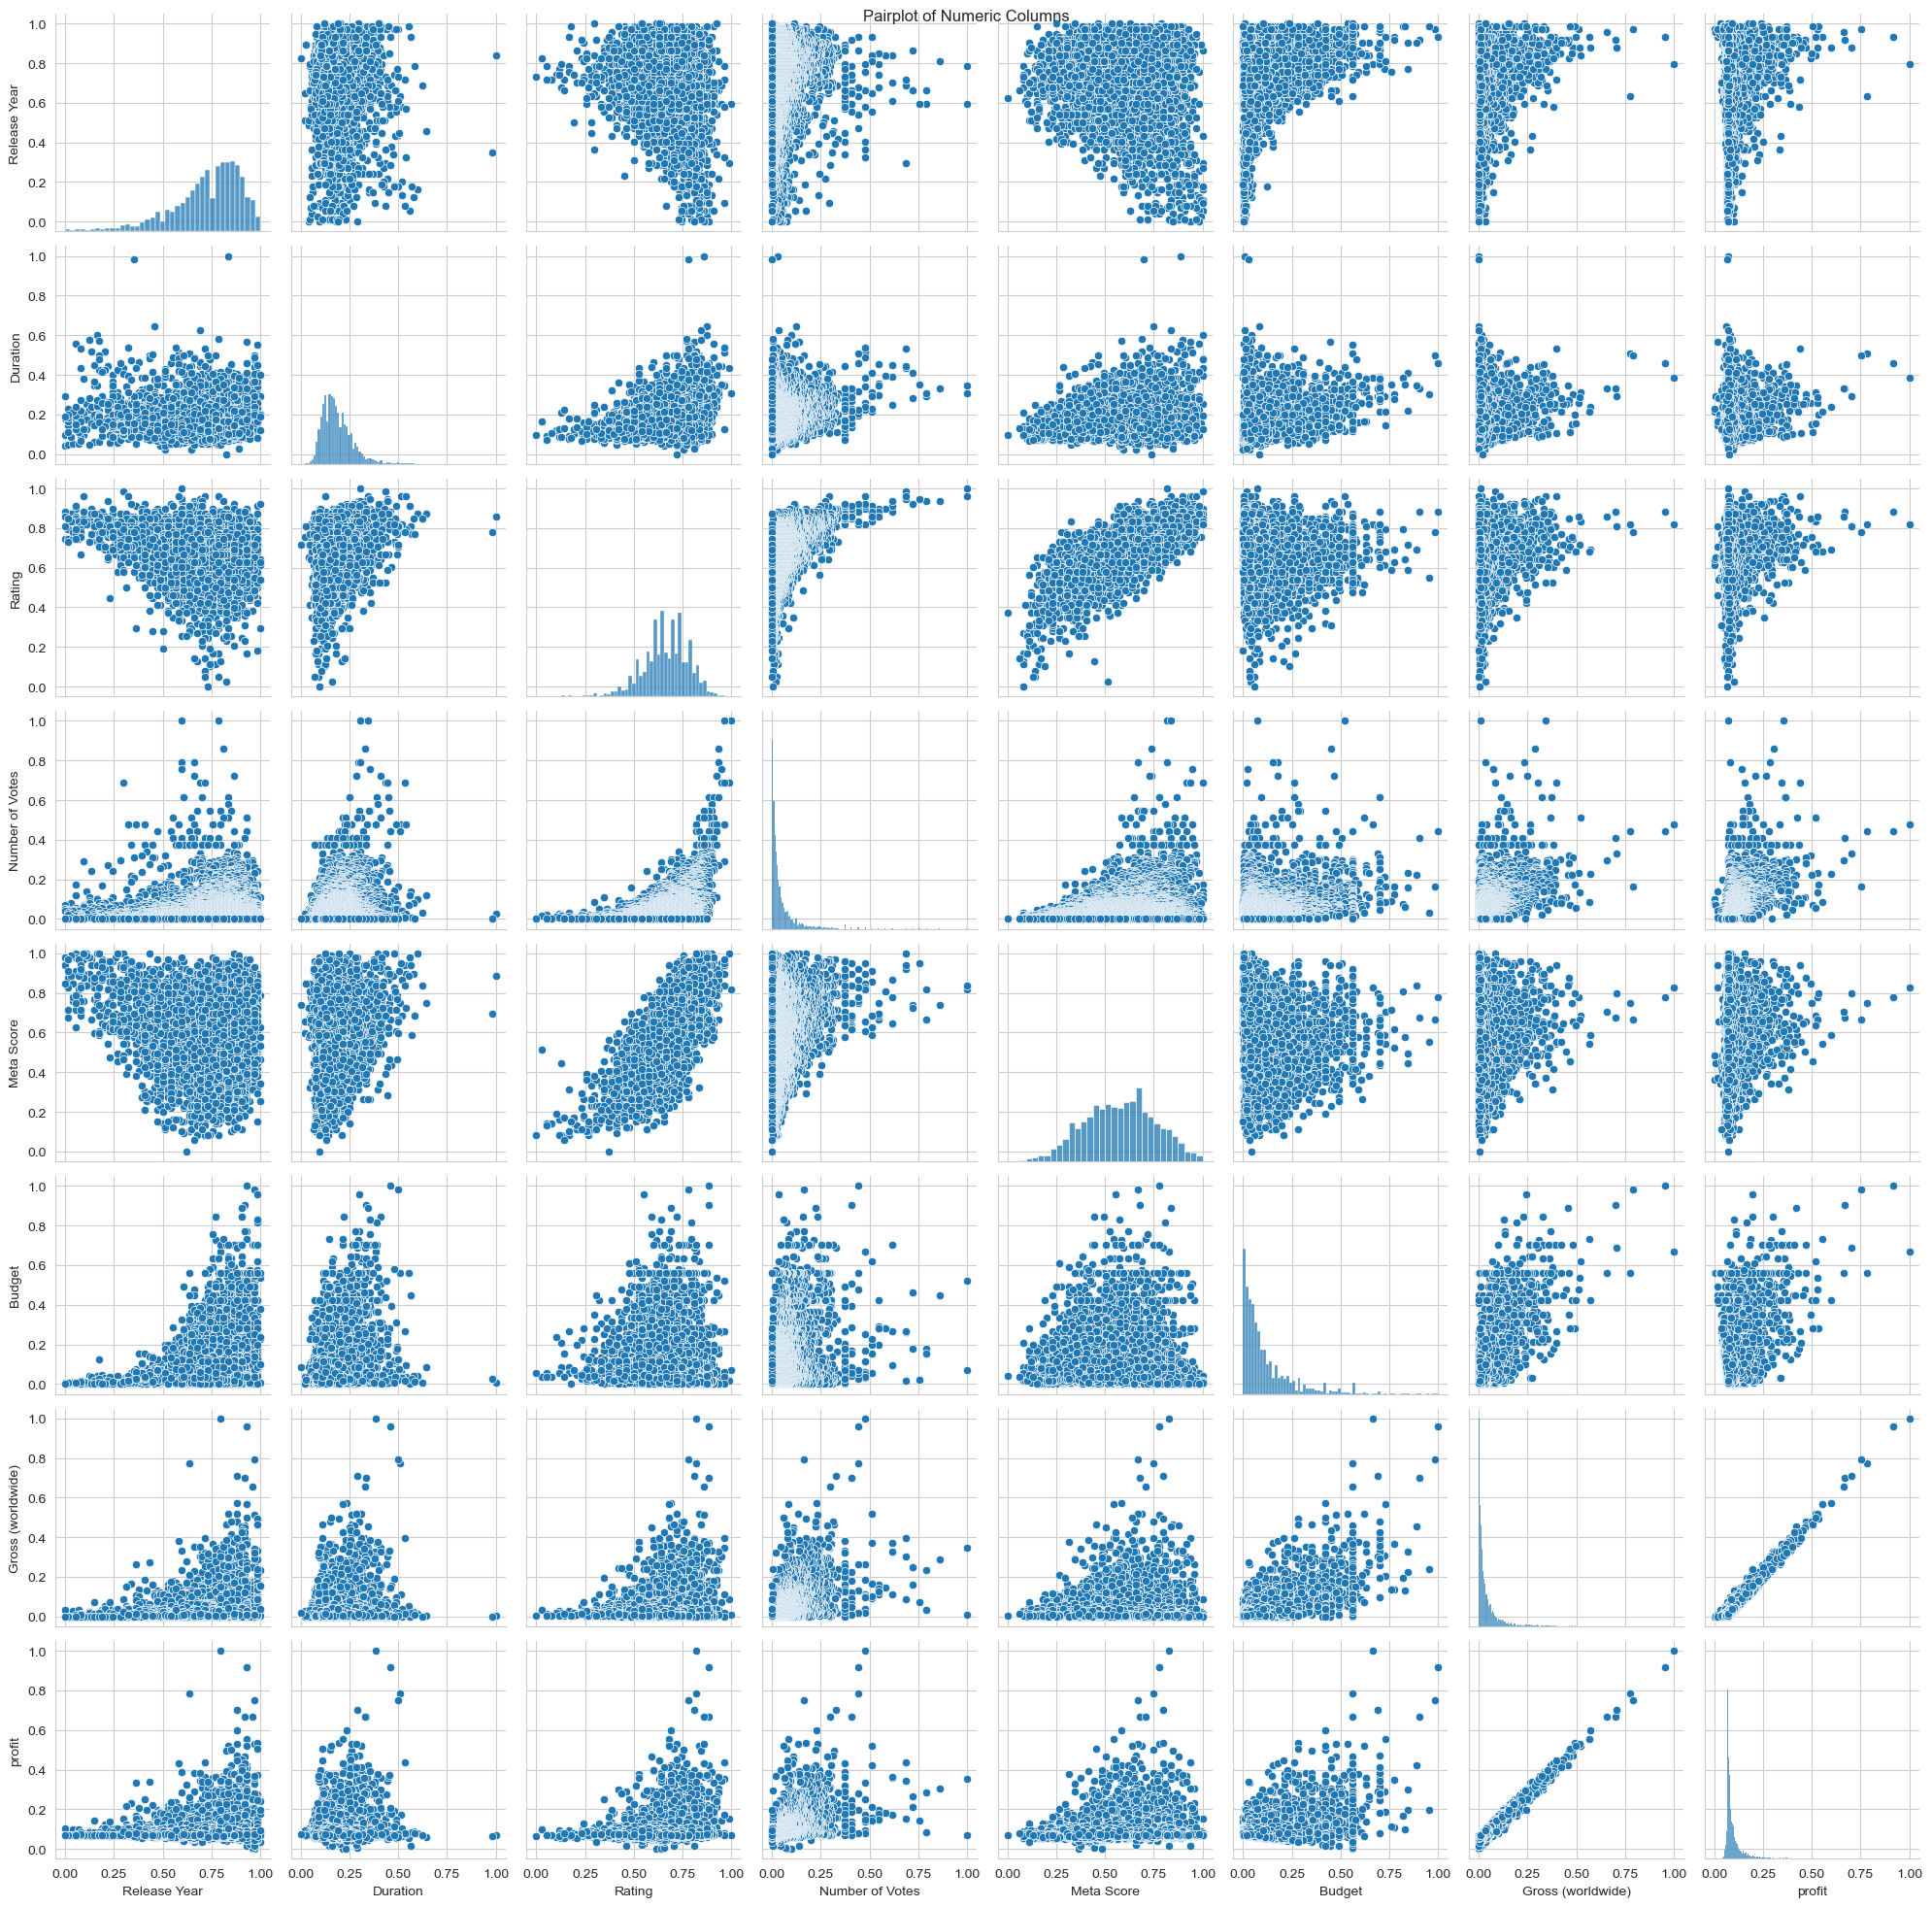

In [30]:
plt.figure(figsize=(10, 10))
sns.pairplot(data=numeric_columns)
plt.suptitle('Pairplot of Numeric Columns')
plt.tight_layout()
plt.show()



In the past, most people who voted for movies tended to give higher ratings. As the years have passed, we observe that ratings have become more spread out, with lower ratings also becoming more common.

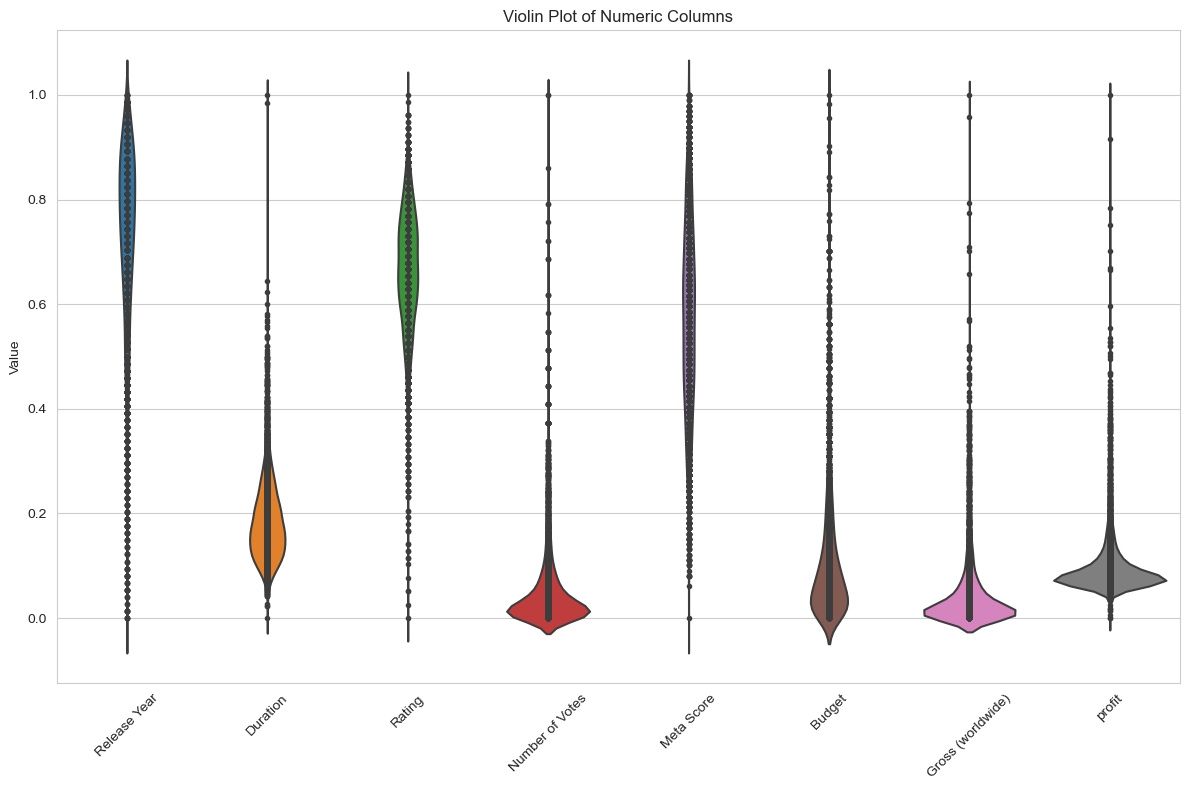

In [31]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=numeric_columns, orient='v', inner='point')
plt.title('Violin Plot of Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
